In [1]:
import io
import os
import spacy
import fastai
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fastai import *
from fastai.text import * 
from fastai.vision import *
from functools import partial
from spacy.symbols import ORTH
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean_tweet(tweet_text):
    return re.sub(r' ?http[^ ]*', r'', tweet_text)

In [3]:
# re1 = re.compile(r'  +')

# def fixup(tweet_text):
#     tweet_text = tweet_text.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
#         'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
#         '', "\n").replace('\\"', '"').replace('','u_n').replace(' @.@ ','.').replace(
#         ' @-@ ','-').replace('\\', ' \\ ')
#     return re1.sub(' ', html.unescape(tweet_text))

In [4]:
# def get_texts(df, n_lbls=1):
#     labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
#     texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
#     for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
#     texts = list(texts.apply(fixup).values)
#     print(len(texts))
#     tok = Tokenizer().proc_all_mp(texts)
#     return tok, list(labels)

# def get_all(df, n_lbls):
#     tok, labels = [], []
#     for i, r in enumerate(df):
#         print(i)
#         tok_, labels_ = get_texts(r, n_lbls)
#         tok += tok_;
#         labels += labels_
#     return tok, labels

In [5]:
# class Tokenizer():
#     def __init__(self, lang='en'):
#         self.re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
#         self.tok = spacy.load(lang)
#         for w in ('','',''):
#             self.tok.tokenizer.add_special_case(w, [{ORTH: w}])

#     def sub_br(self,x): return self.re_br.sub("\n", x)

#     def spacy_tok(self,x):
#         return [t.text for t in self.tok.tokenizer(self.sub_br(x))]

#     re_rep = re.compile(r'(\S)(\1{3,})')
#     re_word_rep = re.compile(r'(\b\w+\W+)(\1{3,})')

#     @staticmethod
#     def replace_rep(m):
#         TK_REP = 'tk_rep'
#         c,cc = m.groups()
#         return f' {TK_REP} {len(cc)+1} {c} '

#     @staticmethod
#     def replace_wrep(m):
#         TK_WREP = 'tk_wrep'
#         c,cc = m.groups()
#         return f' {TK_WREP} {len(cc.split())+1} {c} '

#     @staticmethod
#     def do_caps(ss):
#         TOK_UP,TOK_SENT,TOK_MIX = ' t_up ',' t_st ',' t_mx '
#         res = []
#         prev='.'
#         re_word = re.compile('\w')
#         re_nonsp = re.compile('\S')
#         for s in re.findall(r'\w+|\W+', ss):
#             res += ([TOK_UP,s.lower()] if (s.isupper() and (len(s)>2))
#                     else [s.lower()])
#         return ''.join(res)

#     def proc_text(self, s):
     
#         s = self.re_rep.sub(Tokenizer.replace_rep, s)
#         s = self.re_word_rep.sub(Tokenizer.replace_wrep, s)
#         s = Tokenizer.do_caps(s)
#         s = re.sub(r'([/#])', r' \1 ', s)
#         s = re.sub(' {2,}', ' ', s)
#         return self.spacy_tok(s)

#     @staticmethod
#     def proc_all(ss, lang):
#         tok = Tokenizer(lang)
#         return [tok.proc_text(s) for s in ss]

#     @staticmethod
#     def proc_all_mp(ss, lang='en', ncpus = None):
#         ncpus = ncpus or num_cpus()//2
#         return Tokenizer.proc_all( ss, lang)

In [6]:
full_data = pd.read_csv('Tweets.csv')
full_data.shape

(14640, 15)

In [7]:
data = full_data[['airline_sentiment', 'text']]
data.columns = ['labels', 'text']
data.head()

,labels,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [8]:
tweets = []

for tweet in data['text']:
    if re.search(r'http', tweet) is not None:
        tweets.append(clean_tweet(tweet))
    else:
        tweets.append(tweet)

data['text'] = tweets

In [9]:
# replace_map = {'labels': {'negative': -1, 'neutral': 0, 'positive': 1}}
# data.replace(replace_map, inplace=True)
# data.head()

In [10]:
data_trn, data_val = train_test_split(data, stratify = data['labels'], test_size = 0.4, random_state = 42)
data_trn.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)
print(data_trn.shape, data_val.shape)
print(data_trn.head())
print(data_val.head())

(8784, 2) (5856, 2)
     labels                                               text
0  positive  @SouthwestAir Flight 3056. Only an hour long b...
1  negative  @USAirways &amp; there are seats together, the...
2  positive  @AmericanAir RDU Customer Service is awesome. ...
3  negative  @united. epic fail. @reagan. no jetway. been h...
4  negative  @USAirways on hold for 1hr, 30min. Not willing...
     labels                                               text
0  positive  @AmericanAir oh it's nothing my issue was alre...
1   neutral  @JetBlue are we scheduled to depart as scheduled?
2   neutral  @SouthwestAir I would be eternally grateful fo...
3  negative  @SouthwestAir plane switch on 636 meant A= bac...
4  negative  @USAirways What a mess caused by the computer ...


In [11]:
data_trn.to_csv('train.csv', header=False, index=False)
data_val.to_csv('test.csv', header=False, index=False)

In [12]:
# data_trn = pd.read_csv('train.csv', header=None)
# data_val = pd.read_csv('test.csv', header=None)

In [13]:
# ------------------------------------------- From Here

In [14]:
# chunksize=25000

# data_trn = pd.read_csv('train.csv', header=None, chunksize=chunksize)
# data_val = pd.read_csv('test.csv', header=None, chunksize=chunksize)

In [15]:
# tok_trn, trn_labels = get_all(data_trn, 1)
# tok_val, val_labels = get_all(data_val, 1)

In [16]:
# np.save('tok_trn.npy', tok_trn)
# np.save('trn_labels.npy', trn_labels)
# np.save('tok_val.npy', tok_val)
# np.save('val_labels.npy', val_labels)

In [17]:
# tok_trn = np.load('tok_trn.npy')
# trn_labels = np.load('trn_labels.npy')
# tok_val = np.load('tok_val.npy')
# val_labels = np.load('val_labels.npy')

In [18]:
# freq = Counter(p for o in tok_trn for p in o)
# freq.most_common(25)

In [19]:
# max_vocab = 60000
# min_freq  = 2
# itos = [o for o,c in freq.most_common(max_vocab) if c > min_freq]
# itos.insert(0, '_pad_')
# itos.insert(0, '_unk_')

In [20]:
# #Creating String key string to integer
# stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [21]:
# trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
# val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [22]:
# ------------------------------------------------ Till Here

In [23]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = data_trn, valid_df = data_val, path = "./")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = data_trn, valid_df = data_val, vocab=data_lm.train_ds.vocab, path = "./")

In [24]:
data_lm.save()
data_clas.save()

In [25]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


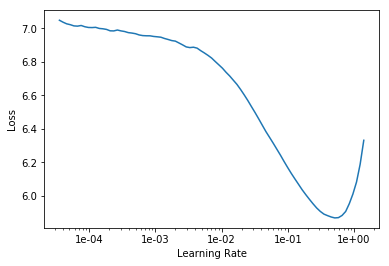

In [26]:
learn.lr_find(start_lr=float('1e-05'), end_lr=float('3'), num_it=100, stop_div=True)
learn.recorder.plot()

In [27]:
# train the learner object with learning rate
learn.freeze_to(-3)
learn.fit_one_cycle(1, 5e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,4.522671,3.939818,0.255706


In [28]:
# Save this encoder to use it for classification later
learn.save_encoder('ft_enc_article_based')

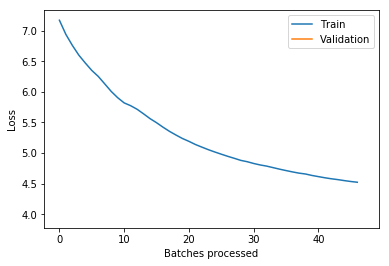

In [29]:
learn.recorder.plot_losses()

In [30]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac xxunk / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj in car xxunk to xxup dfw . xxmaj pulled over 1hr ago - very icy roads . xxmaj on - hold with xxup aa since 1hr . xxmaj ca n't reach xxunk for xxup xxunk . xxmaj xxunk 2 do ?,negative
"xxbos @usairways xxmaj customer service is dead . xxmaj last xxunk , flts delayed / xxmaj cancelled xxmaj flighted . xxmaj bags lost 4 days . xxmaj last nt , flt delayed / xxmaj cancelled xxmaj flighted . xxmaj no meal voucher ?",negative
xxbos @americanair xxmaj all flts to xxup jfk xxmaj cancelled xxmaj flightled xxmaj thx to xxup ur agent at xxup sfo i m rebooked on xxup ua . xxmaj did n't get name . xxmaj she was awesome ! # xxunk # xxunk,negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


In [31]:
# Use the data_clas object we created earlier to build a classifier with our fine-tuned encoder
classifier = text_classifier_learner(data_clas, drop_mult=0.5)
classifier.load_encoder('ft_enc_article_based')

In [32]:
# We will again try to fit our model
classifier.fit_one_cycle(1, 5e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.717778,0.767428,0.759904


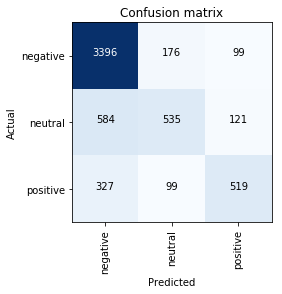

In [33]:
# Get predictions
preds, targets, losses = classifier.get_preds(with_loss=True)
interp = ClassificationInterpretation(data_clas, preds, targets, losses)
interp.plot_confusion_matrix()